#  <center> <u>Warsztaty badawcze - praca domowa 5 <br> <br> Partial Dependence Profiles (PDP) oraz Accumulated Local Dependence (ALE) </u> </center>   

**Zbiór danych:**

Wykorzystamy zbiór danych medycznych [UCI Heart Disease](https://archive.ics.uci.edu/ml/datasets/heart+disease), który zawiera wiek, płeć oraz wyniki badań medycznych pacjenta.

**Model:** 

Jako modele wykorzystany zostanie Random Forest oraz SVC.

In [4]:
import pickle
import dalex as dx
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [5]:
#wczytanie modeli
rf = pickle.load(open("./Modele/random_forest", 'rb'))
svc = pickle.load(open("./Modele/svc2", 'rb'))

# wczytanie zbioru danych
data = pd.read_csv("./heart_data.csv")

# odzielenie targetu od innych zmiennych
y = data.target.values
x = data.drop(['target'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state=0, stratify=y)

In [6]:
# stworzenie explainerów
explainer_rf = dx.Explainer(rf, x_train, y_train, label = "Random Forest")
explainer_svc = dx.Explainer(svc, x_train, y_train, label = "SVC")

Preparation of a new explainer is initiated

  -> data              : 242 rows 20 cols
  -> target variable   : 242 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function yhat_proba_default at 0x00000202BAF33790> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0322, mean = 0.46, max = 0.988
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.738, mean = -0.00088, max = 0.81
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 242 rows 20 cols
  -> target variable   : 242 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : SVC
  -> predict function  : <function yhat

## Część 1: Profile PDP

In [7]:
pdp_rf = explainer_rf.model_profile(random_state=0)
pdp_svc = explainer_svc.model_profile(random_state=0)

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.70it/s]


### Profile PDP dla Random Forest

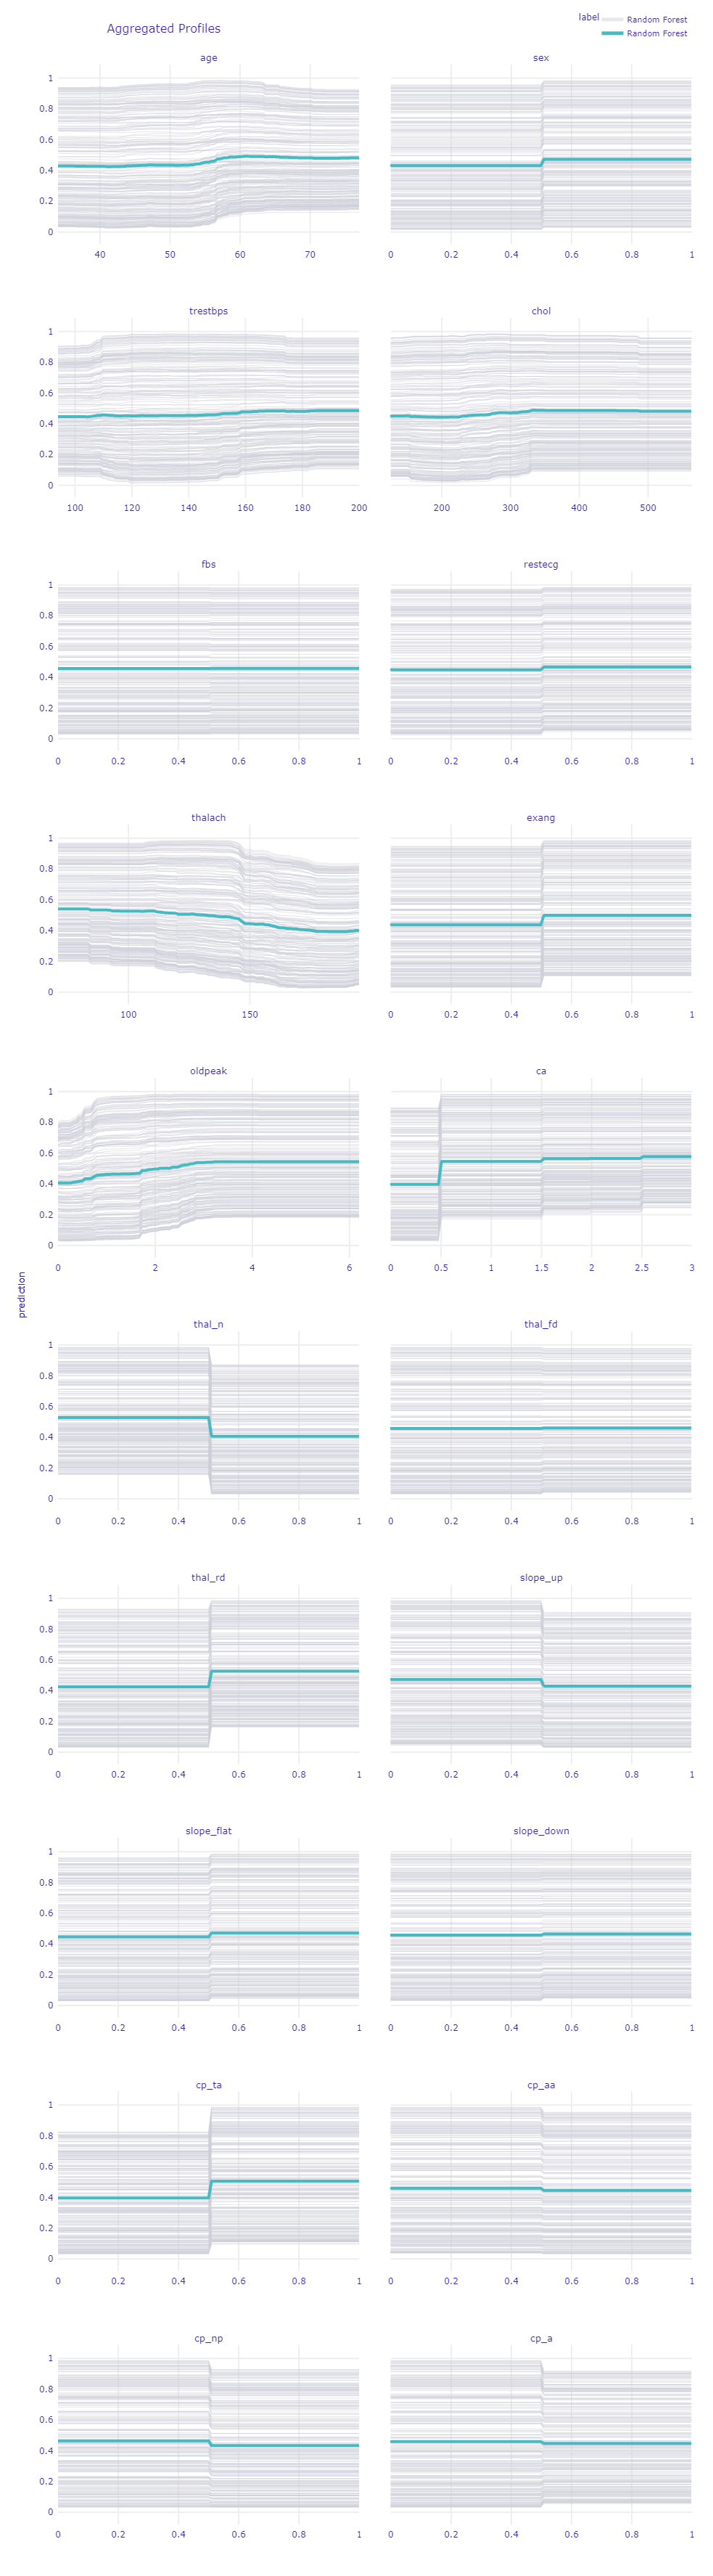

In [3]:
#pdp_rf.plot(geom="profiles") <- profile policzone osobno i zaimortowany sam wykres ze względu na zajmowaną pamięć
from IPython.display import Image
Image("PDP.png")

**Wnioski:**
- Wpływ zmiennych objąsniających pokrywa się z tym co móglismy zauważyć przy wyjaśnieniach lokalnych. Oczywiście dla niektórych obserwacji wykres byłby np. troszkę bardziej stromy, ale w ogólności trend byłby taki sam.
- Ze względu na to, że rozważany zbiór jest dość mały, to na wykresie linie siwe reprezentują wszystkie obserwacje. Dzięki temu możemy też zauważyć różnice wpływu zmiennych dla mniejszych predykcji (osób zdrowych) i większych (osób chorych). Np. dla wieku (pierwszy wykres) widzimy, że dla osób zdrowych dodatni wpływ na predykcję zanotujemy po przekroczeniu 50 lat, natomiast dla osób chorych zmiany wieku nie mają aż takiego znaczenia, a wręcz mają lekką tendencję spadkową.

###  Profile PDP dla Random Forest (grupowanie po sex i ca)
Przy analizie profilów PDP warto tez sprawdzić jak będą one wyglądały gdy pogrupujemy je po jakiejść zmiennej. Wykorzystamy tutaj sex i ca. Dla lepszej czytelności, wykresy ponizej zostały wykonane tylko dla kilku zmiennych objaśniających.

In [8]:
pdp_rf_sex = explainer_rf.model_profile(random_state=0, groups ='sex')
pdp_rf_sex.plot(color='_groups_', variables = ['age', 'trestbps','chol','fbs','restecg','thalach','oldpeak','ca'])

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


**Wnisoki:**
- Choć płeć z medycznego punktu widzenia może mieć spore znaczenie w przewidywaniu choroby wieńcowej serca oraz w poprzednich wyjaśnieniach lokalnych również często była dobrym predyktorem, to w uśrednionych wartościach nie widzimy większych różnic.

In [9]:
pdp_rf_ca = explainer_rf.model_profile(random_state=0, groups = 'ca')
pdp_rf_ca.plot(color='_groups_', variables = ['age','trestbps','chol','thalach','exang','oldpeak','thal_n','thal_rd'])

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


**Wnioski:**
- Widzimy znaczną różnicę w zachowaniu wykresów dla ca=0 (kolor zielony) a ca = 1,2 lub 3 (pozostałe kolory). 
- Przykład: dla zmiennej oldpeak dla wartości ca=1,2,3 nawet minimalny wzrost do 0.5-1 (niewielkie odchylenie od "normy") znacząco zwiększa predykcję. Dla ca=0 wpływ ten jest znacznie łagodniejszy.
- Przypominając, ca oznacza uwapnienie i występowanie już jakichkolwiek uwapnień może znacząco zwiększyć ryzyko choroby wieńcowej serca, stąd nie zaskakują nas powyższe różnice.

### Porównanie PDP dla Random Forest i SVC

In [10]:
pdp_rf.plot([pdp_svc])

**Wnioski:**
- SVC jest liniowy, Random Forest schodkowy, dzięki czemy lepiej wyłapuje różnice w zmiennych po one-hot-encoding
- Dla większości zmiennych modele zachowują się podobnie. Różnice możemy zauważyć dla wieku, gdzie SVC jest wręcz poziomy, a dla lasu losowego widzimy znaczące zwiększenie predykcji dla starszych osób. Z medycznego punktu widzenia naturalne jest, że wraz z wiekiem rośnie ryzyko choroby wieńcowej serca, więc las losowy poradził sobie lepiej, bo wyłapał tę zależność.

## Część 2: Profile ALE

In [11]:
ale_rf = explainer_rf.model_profile(type = 'accumulated', random_state=0)
ale_svc = explainer_svc.model_profile(type = 'accumulated', random_state=0)

Calculating accumulated dependency: 100%|██████████████████████████████████████████████| 20/20 [00:02<00:00,  8.62it/s]


### Porównanie profili ALE dla RandomForest i SVC

In [12]:
ale_rf.plot(ale_svc)

**Wnioski:**
- Podobnie jak w przypadku profili PDP, zmienne mają podobny wpływ oprócz zmiennej wiek.

### Porównanie profilu PDP i ALE dla Random Forest

In [13]:
ale_rf.result['_label_'] = "ALE"
pdp_rf.result['_label_'] = "PDP"
pdp_rf.plot(ale_rf)

**Wnioski:**
- Dzięki porównaniu profili PDP i ALE możemy ocenić czy w naszym modelu występują interakcje pomiędzy zmiennymi. Dla każdej zmiennej wykresy są "równoległe" (tzn. kształt zachowują ten sam a są jedynie przesunięte względem wysokości), co wskazuje na to, że nasz model prawdopodobnie jest addytywny.

## Część 3: Podsumowanie

- Wykresy proflili PDP pokrywają się z ogólnym trendem wpływu zmiennych na predykcję z poprzednich wyjaśnień oraz z interpretacja medyczną.
- Utwierdzamy się w ważności zmiennych takich jak ca, cp, thal, sex czy oldpeak.
- W naszym modelu nie występują interakcje pomiędzy zmiennymi -> możliwosć addytywności.
- Warto przy profilach PDP rozważać podział na grupy, gdyż ogólny wpływ zmiennej może być różny dla różnych wartości (tak jak w przypadku omawianego ca).